In [2]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

test_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text', 'label'])
test_df.head()


imdb_test_df = pd.read_csv('data/test_imdb_split.csv')

imdb_test_df.head()


import torch
import torch.nn as nn

class MLP_Model(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP_Model, self).__init__()

        self.layers = nn.ModuleDict({
            "Layer 1": nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 2": nn.Sequential(
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 3": nn.Sequential(
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 4": nn.Sequential(
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 5": nn.Linear(hidden_sizes[3], output_size)
        })

    def forward(self, x):
        for name, layer in self.layers.items():
            x = layer(x)
        return x

model = MLP_Model()
print(model)


# ### Preprocessing

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# %%
import joblib
BATCH_SIZE = 32

vectorizer = CountVectorizer()
vectorizer = joblib.load('vectorizer.pkl')

# Collate function for BoW
def bow_collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack batch into texts and labels
    X_batch = vectorizer.transform(texts).toarray()  # Vectorize texts using BoW
    X_batch_tensor = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
    y_batch_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor (for classification tasks)
    return X_batch_tensor, y_batch_tensor

test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist())
test_loader_bow = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)
print(f"Number of test batches: {len(test_loader_bow)}")

test_imdb_dataset = TextDataset(imdb_test_df["text"].tolist(), imdb_test_df["label"].tolist())
test_loader_bow_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)
print(f"Number of test batches: {len(test_loader_bow_imdb)}")


# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# %%
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

bert = AutoModel.from_pretrained(model_name)

embedding_size = bert.config.hidden_size
print('Embedding size:',embedding_size)

def get_bert_embeddings(inputs, bert, pooling_strategy='mean'):
    device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert.to(device)
    with torch.no_grad():
        outputs = bert(**inputs)
        
    embeddings = outputs.last_hidden_state
    
    if pooling_strategy == 'mean':
        sentence_embeddings = torch.mean(embeddings, dim=1)  # Mean pooling
    elif pooling_strategy == 'max':
        sentence_embeddings = torch.max(embeddings, dim=1).values  # Max pooling
    elif pooling_strategy == 'cls':
        sentence_embeddings = embeddings[:, 0, :]  # CLS token
    elif pooling_strategy == 'sep':
        sentence_embeddings = embeddings[:, -1, :]  # SEP token
    else:
        raise ValueError("Pooling strategy not valid")

    return sentence_embeddings

def bert_collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = None
    if isinstance(batch[0], tuple) and len(batch[0]) > 1:
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    sentence_embeddings = get_bert_embeddings(inputs, bert, pooling_strategy=pooling_strategy)

    return sentence_embeddings.cpu() , labels

BATCH_SIZE = 32
pooling_strategy = 'mean'  

test_loader_bert = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)
print(f"Number of test batches: {len(test_loader_bert)}")

test_loader_bert_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bert_collate_fn)
print(f"Number of test batches: {len(test_loader_bert_imdb)}")

# %% [markdown]
# ### Testing

# %%
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred_logits = model(X_batch)  # shape: (batch_size, num_classes)
            loss = criterion(y_pred_logits, y_batch)
            test_loss += loss.item()

            # Get predicted labels
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)  # Predicted class indices

            # Collect true and predicted labels for metrics
            all_y_true.extend(y_batch.cpu().numpy())
            all_y_pred.extend(y_pred_labels.cpu().numpy())

    # Average test loss over all batches
    test_loss /= len(test_loader)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix


MLP_Model(
  (layers): ModuleDict(
    (Layer 1): Sequential(
      (0): Linear(in_features=10000, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 5): Linear(in_features=64, out_features=2, bias=True)
  )
)
Number of test batches: 57
Number of test batches: 313
cpu
BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]

<ipython-input-4-adbab20603e8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bow_model.load_state_dict(torch.load('/kaggle/input/models/bow_1.pt', map_location=torch.devi

Test Loss: 1.1444
Accuracy: 0.8012


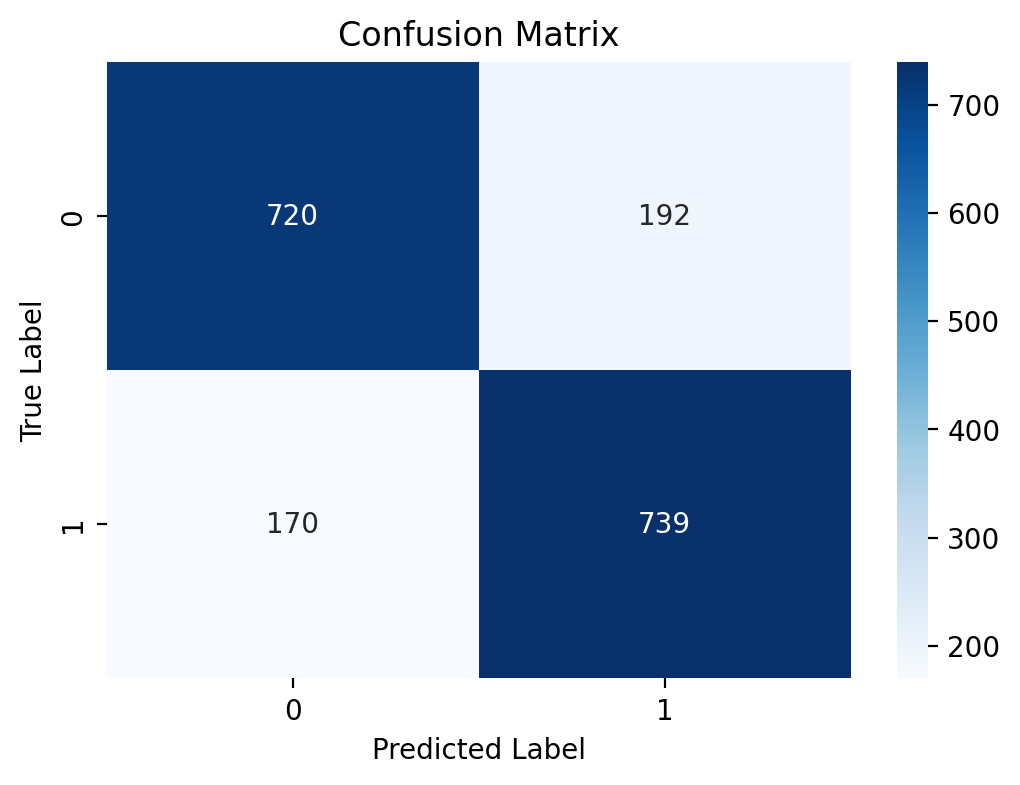

Test Loss: 7.9610
Accuracy: 0.7633


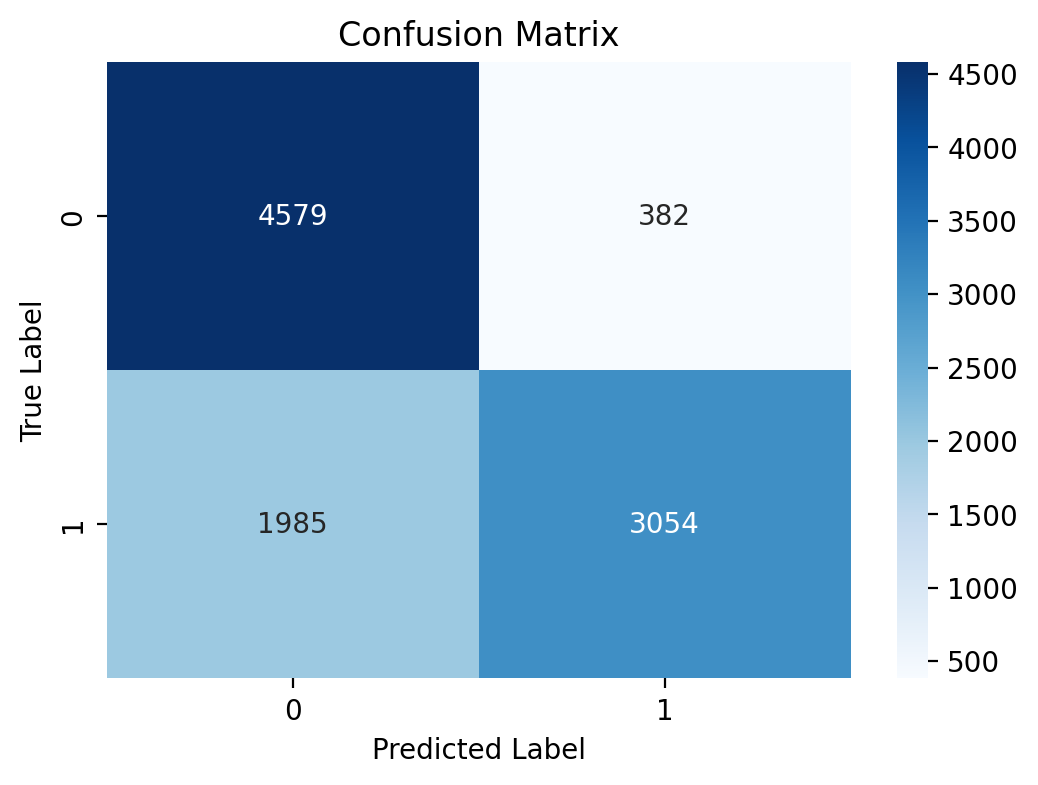

In [ ]:
# #### BOW Trained on Dataset 1

# %%
bow_model = MLP_Model(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3)
bow_model.load_state_dict(torch.load('models/bow_1.pt', map_location=torch.device('cpu')))
bow_model.to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()

accuracy_bow_11, conf_matrix_bow_11 = test(bow_model, criterion, test_loader_bow, device)
accuracy_bow_12 , conf_matrix_bow_12 = test(bow_model, criterion, test_loader_bow_imdb, device)

# %% [markdown]

<ipython-input-5-042af01c3d3a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bow_model2.load_state_dict(torch.load('/kaggle/input/models/bow_2.pt', map_location=torch.dev

Test Loss: 0.9520
Accuracy: 0.7963


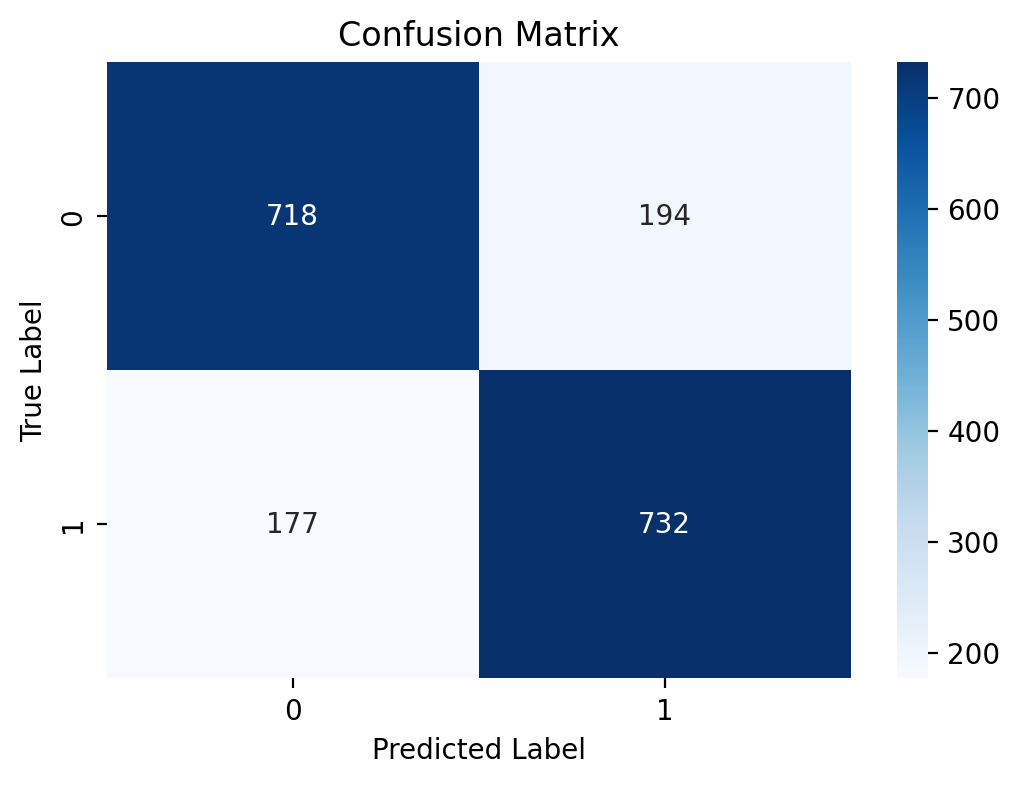

Test Loss: 0.6396
Accuracy: 0.8826


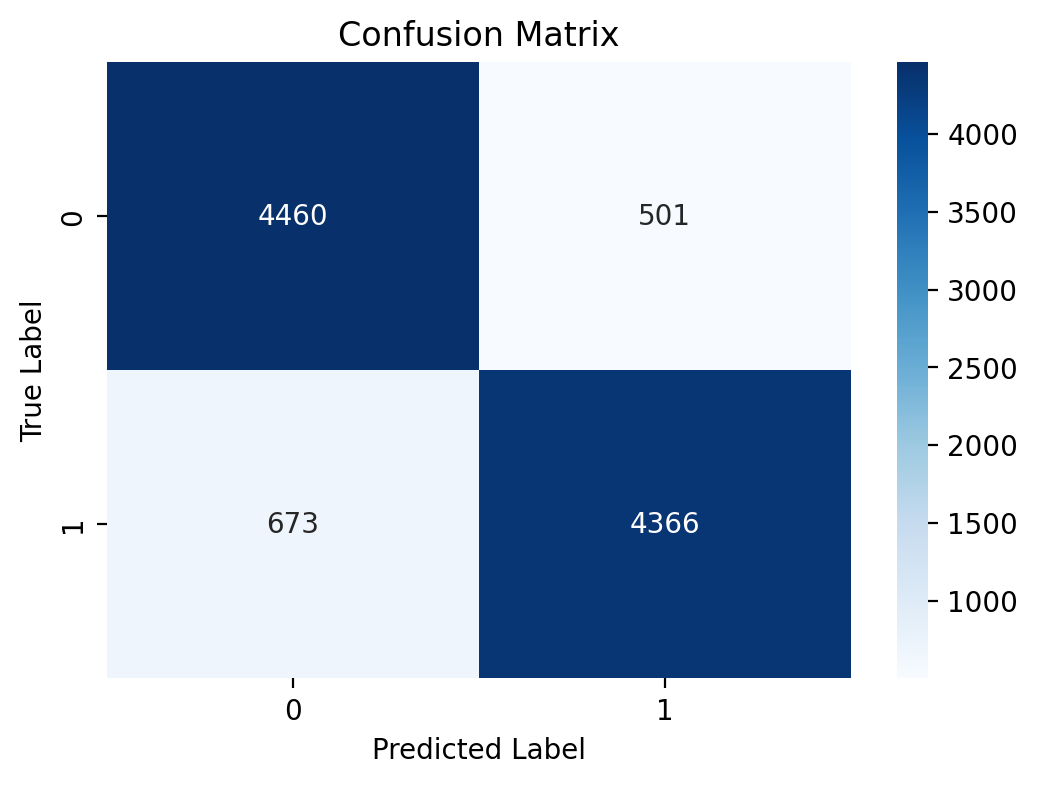

In [ ]:
# #### Bow Tuned on Dataset 2

# %%

bow_model2 = MLP_Model(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3)
bow_model2.load_state_dict(torch.load('models/bow_2.pt', map_location=torch.device('cpu')))
bow_model2.to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()

accuracy_bow_21, conf_matrix_bow_21 = test(bow_model2, criterion, test_loader_bow, device)
accuracy_bow_22, conf_matrix_bow_22 = test(bow_model2, criterion, test_loader_bow_imdb, device)


<ipython-input-6-e6c9928a5124>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_model.load_state_dict(torch.load('/kaggle/input/models/bert_1.pt', map_location=torch.de

Test Loss: 0.3167
Accuracy: 0.8655


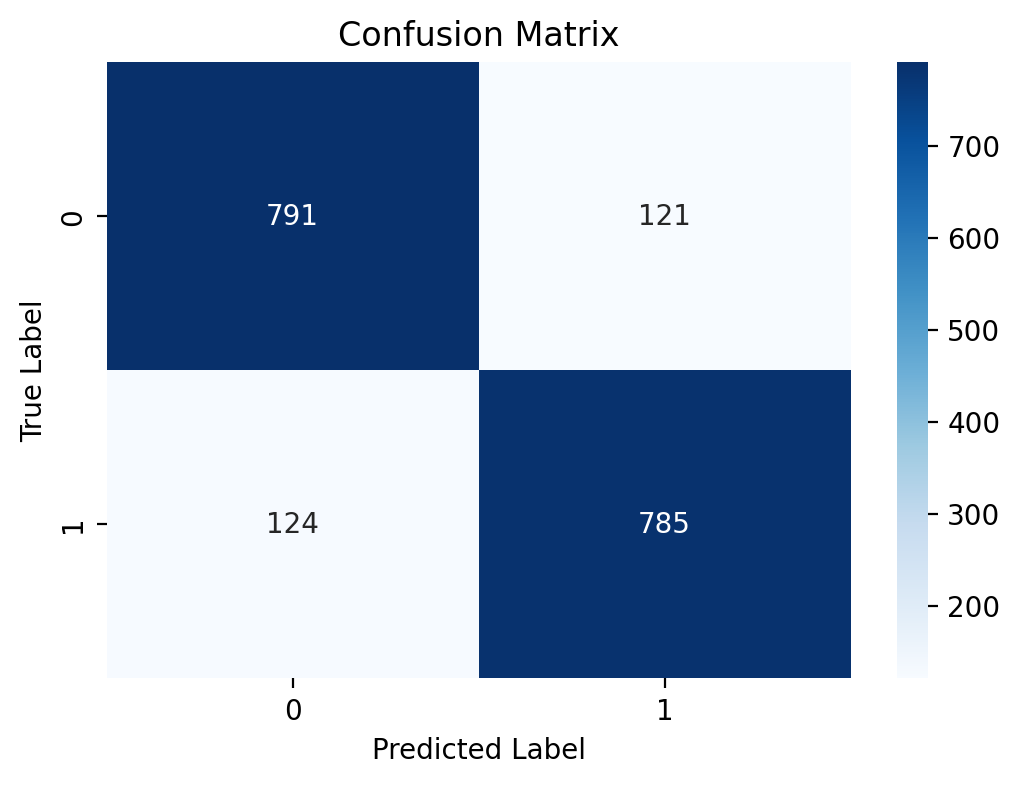

Test Loss: 0.4268
Accuracy: 0.8119


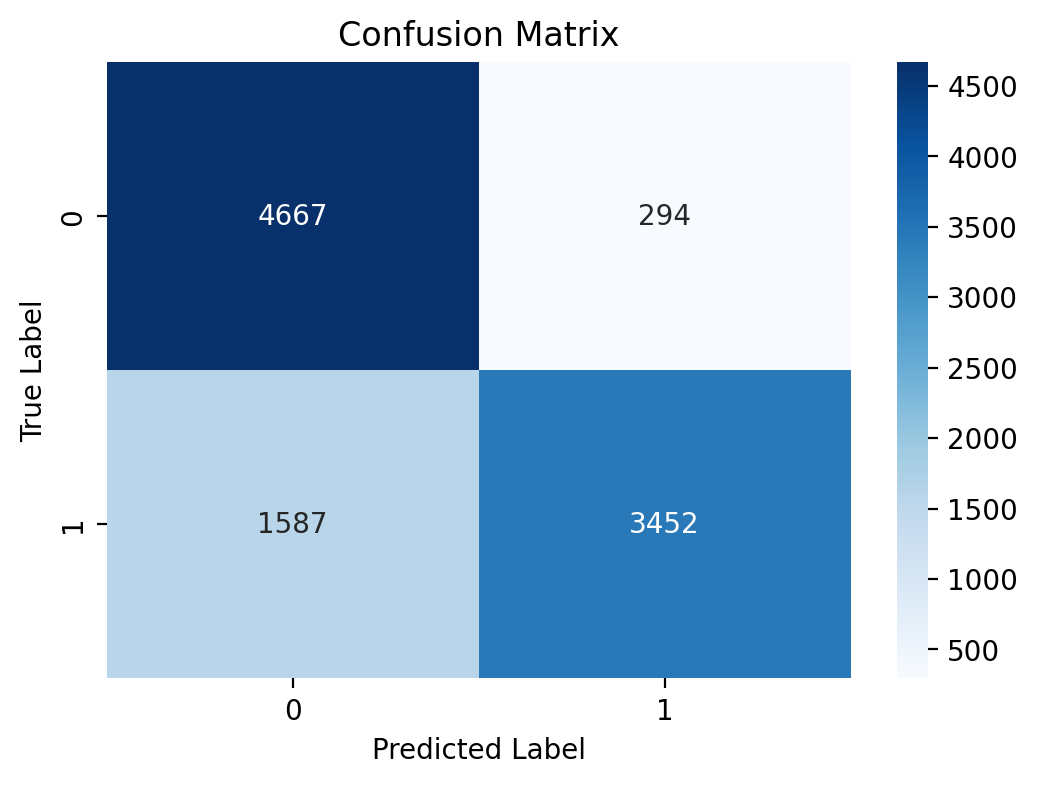

In [ ]:
# %% [markdown]
# #### Bert Trained on Dataset 1
# %%
bert_model = MLP_Model(input_size=768, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3)
bert_model.load_state_dict(torch.load('models/bert_1.pt', map_location=torch.device('cpu')))
bert_model.to(device) 


criterion = nn.CrossEntropyLoss()

accuracy_bert_11, conf_matrix_bert_11 = test(bert_model, criterion, test_loader_bert, device)
accuracy_bert_12, conf_matrix_bert_12 = test(bert_model, criterion, test_loader_bert_imdb, device)

<ipython-input-7-ccbf47d4945a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_model_2.load_state_dict(torch.load('/kaggle/input/models/bert_2.pt', map_location=torch.

Test Loss: 0.4257
Accuracy: 0.8342


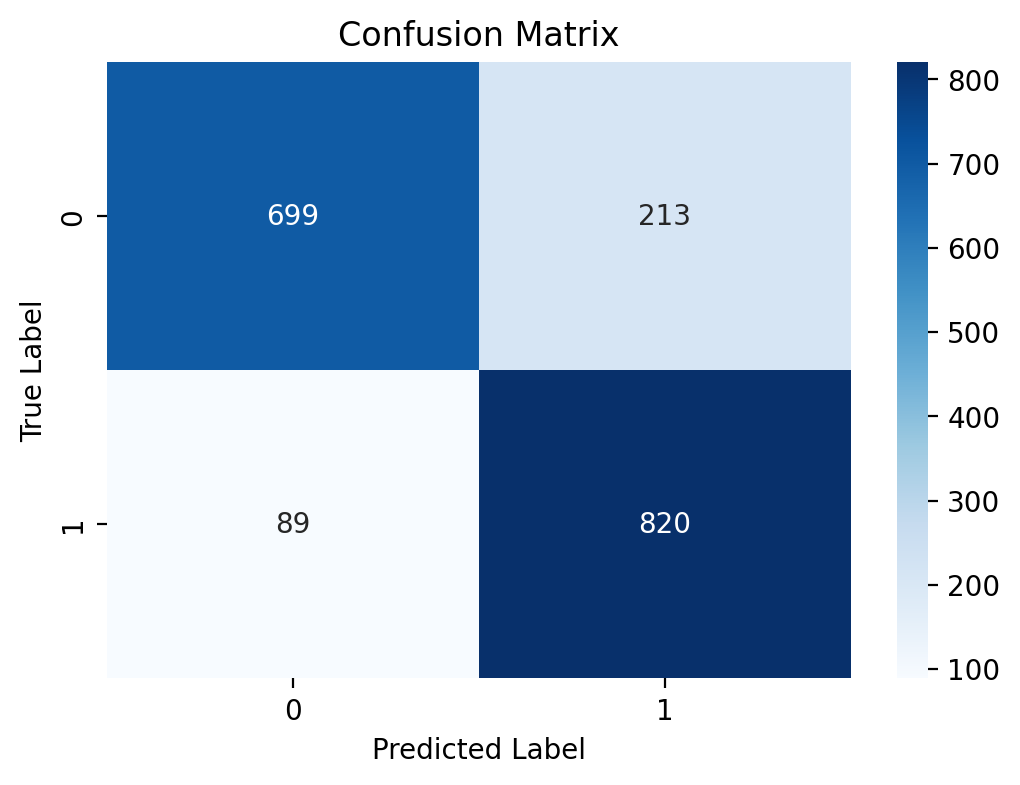

Test Loss: 0.2663
Accuracy: 0.8890


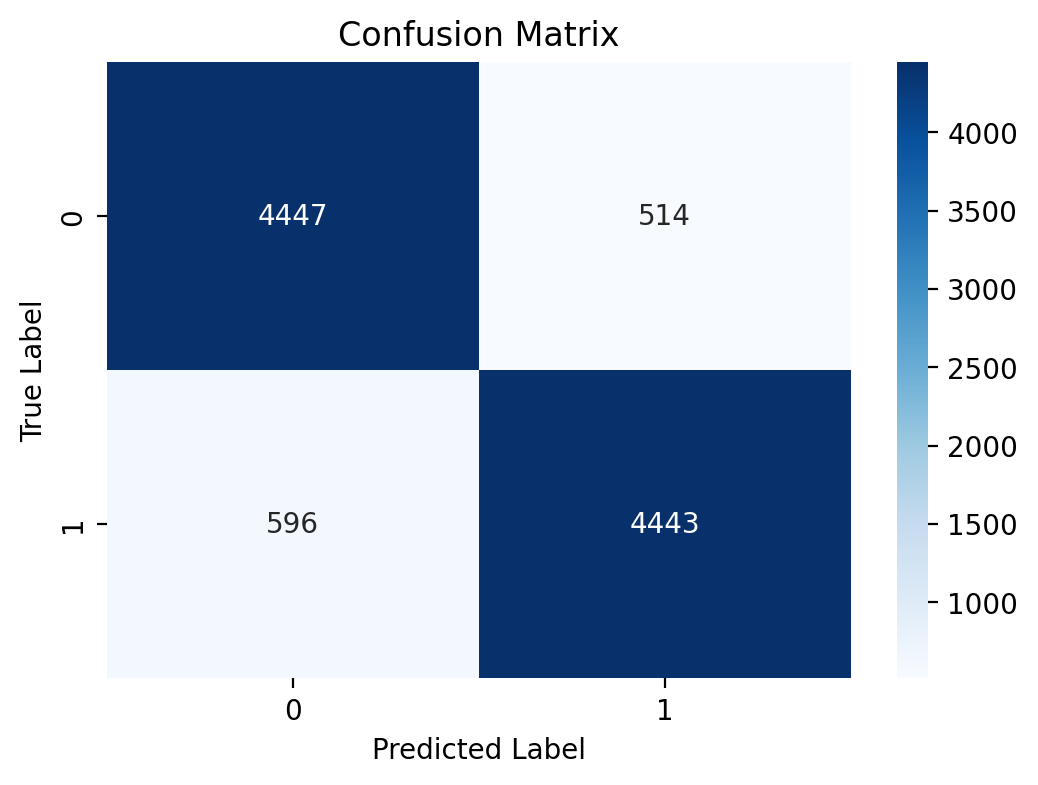

In [ ]:
# %% [markdown]
# #### Bert Tuned on Dataset 2

# %%
bert_model_2 = MLP_Model(input_size=768, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3)
bert_model_2.load_state_dict(torch.load('models/bert_2.pt', map_location=torch.device('cpu')))
bert_model_2.to(device) 

criterion = nn.CrossEntropyLoss()

accuracy_bow_21, conf_matrix_bow_21 = test(bert_model_2, criterion, test_loader_bert, device)
accuracy_bow_22, conf_matrix_bow_22 = test(bert_model_2, criterion, test_loader_bert_imdb, device)


In [ ]:
import numpy as np

# Create a dictionary with all accuracy values and confusion matrices
results = {
    "accuracy_bow_11": accuracy_bow_11,
    "conf_matrix_bow_11": conf_matrix_bow_11,
    "accuracy_bow_12": accuracy_bow_12,
    "conf_matrix_bow_12": conf_matrix_bow_12,

    "accuracy_bow_21": accuracy_bow_21,
    "conf_matrix_bow_21": conf_matrix_bow_21,
    "accuracy_bow_22": accuracy_bow_22,
    "conf_matrix_bow_22": conf_matrix_bow_22,

    "accuracy_bert_11": accuracy_bert_11,
    "conf_matrix_bert_11": conf_matrix_bert_11,
    "accuracy_bert_12": accuracy_bert_12,
    "conf_matrix_bert_12": conf_matrix_bert_12,

    "accuracy_bert_21": accuracy_bow_21,  # Check variable name
    "conf_matrix_bert_21": conf_matrix_bow_21,
    "accuracy_bert_22": accuracy_bow_22,
    "conf_matrix_bert_22": conf_matrix_bow_22
}

# Save as NumPy .npz file
np.savez("all_results.npz", **results)


In [7]:
# Load results from .npz
loaded_data = np.load("all_results.npz", allow_pickle=True)

# Extract values
accuracy_bow_11 = loaded_data["accuracy_bow_11"].item()
conf_matrix_bow_11 = loaded_data["conf_matrix_bow_11"]
accuracy_bow_12 = loaded_data["accuracy_bow_12"].item()
conf_matrix_bow_12 = loaded_data["conf_matrix_bow_12"]

accuracy_bow_21 = loaded_data["accuracy_bow_21"].item()
conf_matrix_bow_21 = loaded_data["conf_matrix_bow_21"]
accuracy_bow_22 = loaded_data["accuracy_bow_22"].item()
conf_matrix_bow_22 = loaded_data["conf_matrix_bow_22"]

accuracy_bert_11 = loaded_data["accuracy_bert_11"].item()
conf_matrix_bert_11 = loaded_data["conf_matrix_bert_11"]
accuracy_bert_12 = loaded_data["accuracy_bert_12"].item()
conf_matrix_bert_12 = loaded_data["conf_matrix_bert_12"]

accuracy_bert_21 = loaded_data["accuracy_bert_21"].item()
conf_matrix_bert_21 = loaded_data["conf_matrix_bert_21"]
accuracy_bert_22 = loaded_data["accuracy_bert_22"].item()
conf_matrix_bert_22 = loaded_data["conf_matrix_bert_22"]

print("Loaded Accuracy for BOW Dataset 1:", accuracy_bow_11)


Loaded Accuracy for BOW Dataset 1: 0.8012081274025261


In [9]:
# %%
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# delete runs folder if it exists
if os.path.exists("runs"):
    import shutil
    shutil.rmtree("runs")

# Initialize TensorBoard writer
writer = SummaryWriter("runs/experiment_logs")

# Model details
model_names = ["bow_1", "bow_2", "bert_1", "bert_2"]
input_sizes = {"bow": 10000, "bert": 768}  # Input size mapping
num_epochs = 10  # Update this as needed

# Loss and accuracy values from provided dataset
train_losses = {
    "bow_1": [0.6917, 0.5854, 0.2842, 0.1238, 0.0573, 0.0267, 0.0166, 0.0102, 0.0063, 0.0054],
    "bert_1": [0.6170, 0.3796, 0.3437, 0.3229, 0.3156, 0.3074, 0.2938, 0.2808, 0.2698, 0.2473],
    "bow_2": [0.8659, 0.2586, 0.1761, 0.1018, 0.0584, 0.0376, 0.0250, 0.0208, 0.0197, 0.0144],
    "bert_2": [0.3273, 0.2994, 0.2883, 0.2825, 0.2775, 0.2699, 0.2663, 0.2616, 0.2575, 0.2536]
}
val_losses = {
    "bow_1": [0.6868, 0.4810, 0.4710, 0.7117, 0.6531, 0.7416, 0.8702, 0.9232, 1.0499, 1.0957],
    "bert_1": [0.4148, 0.3161, 0.3052, 0.3018, 0.3093, 0.2941, 0.2953, 0.3101, 0.2991, 0.3097],
    "bow_2": [0.3077, 0.2743, 0.3093, 0.3514, 0.3898, 0.4773, 0.5380, 0.5733, 0.5530, 0.6441],
    "bert_2": [0.2958, 0.3128, 0.2864, 0.2735, 0.2690, 0.2685, 0.2716, 0.2610, 0.2621, 0.2626]
}
val_accuracies = {
    "bow_1": [0.5181, 0.7760, 0.8027, 0.7616, 0.8078, 0.8100, 0.7926, 0.7941, 0.7934, 0.7948],
    "bert_1": [0.8129, 0.8540, 0.8605, 0.8736, 0.8548, 0.8678, 0.8707, 0.8605, 0.8656, 0.8714],
    "bow_2": [0.8720, 0.8892, 0.8830, 0.8838, 0.8848, 0.8850, 0.8845, 0.8838, 0.8866, 0.8822],
    "bert_2": [0.8722, 0.8645, 0.8771, 0.8842, 0.8869, 0.8895, 0.8848, 0.8912, 0.8920, 0.8919]
}

# Log accuracy and loss metrics per epoch
for epoch in range(num_epochs):
    for model_name in model_names:
        writer.add_scalar(f"Loss/Train_{model_name}", train_losses[model_name][epoch], epoch)
        writer.add_scalar(f"Loss/Validation_{model_name}", val_losses[model_name][epoch], epoch)
        writer.add_scalar(f"Accuracy/Validation_{model_name}", val_accuracies[model_name][epoch], epoch)

# Log loss curves in a grouped format
for epoch in range(num_epochs):
    for model_name in model_names:
        writer.add_scalars(f"Loss_Curves_{model_name}", {
            "Train": train_losses[model_name][epoch], 
            "Validation": val_losses[model_name][epoch]
        }, epoch)


# Function to log confusion matrix as an image
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    return fig

# Class names for confusion matrix
class_names = ["Class 0", "Class 1"]  # Modify based on your dataset

# Grouped Accuracy Plots for Dataset 1
writer.add_scalars("Accuracy/Dataset_1", {
    "BOW_1": accuracy_bow_11,
    "BOW_2": accuracy_bow_21,
    "BERT_1": accuracy_bert_11,
    "BERT_2": accuracy_bert_21
}, 0)

# Grouped Accuracy Plots for Dataset 2
writer.add_scalars("Accuracy/Dataset_2", {
    "BOW_1": accuracy_bow_12,
    "BOW_2": accuracy_bow_22,
    "BERT_1": accuracy_bert_12,  
    "BERT_2": accuracy_bert_22 
}, 0)

# Confusion Matrices (kept separate for better visualization)
writer.add_figure("Confusion_Matrix/BOW_Dataset1", plot_confusion_matrix(conf_matrix_bow_11, class_names))
writer.add_figure("Confusion_Matrix/BOW_Dataset1_IMDB", plot_confusion_matrix(conf_matrix_bow_12, class_names))

writer.add_figure("Confusion_Matrix/BOW_Dataset2", plot_confusion_matrix(conf_matrix_bow_21, class_names))
writer.add_figure("Confusion_Matrix/BOW_Dataset2_IMDB", plot_confusion_matrix(conf_matrix_bow_22, class_names))

writer.add_figure("Confusion_Matrix/BERT_Dataset1", plot_confusion_matrix(conf_matrix_bert_11, class_names))
writer.add_figure("Confusion_Matrix/BERT_Dataset1_IMDB", plot_confusion_matrix(conf_matrix_bert_12, class_names))

writer.add_figure("Confusion_Matrix/BERT_Dataset2", plot_confusion_matrix(conf_matrix_bert_21, class_names))
writer.add_figure("Confusion_Matrix/BERT_Dataset2_IMDB", plot_confusion_matrix(conf_matrix_bert_22, class_names))

# Close the writer
writer.close()


# Close the writer
writer.close()

| Model   | Dataset 1 Accuracy | Dataset 2 Accuracy |
|---------|-------------------|-------------------|
| bow_1   | 0.8012            | 0.7633            |
| bow_2   | 0.7963            | 0.8826            |
| bert_1  | 0.8655            | 0.8119            |
| bert_2  | 0.8342            | 0.8890            |
